  ADIAS kernel - @copyright adias team
* this notebook is owned by adias team and the team members have the right to edit,change,and customise this kernel.

* the team members may add this kernel to their kaggle profile and remove this header if they wanted to


Introductory information on Melanoma from  [Anshul Sharma's notebook](https://www.kaggle.com/anshuls235/siim-isic-melanoma-analysis-eda-prediction)

# <a id='mel'>1. What is Melanoma?</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>
## -> Overview
<img src='https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/43/ds00190_-ds00439_im04411_mcdc7_melanomathu_jpg.jpg' style="width:500px;height:300px;">
Melanoma, the most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color. Melanoma can also form in your eyes and, rarely, inside your body, such as in your nose or throat.

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma. Limiting your exposure to UV radiation can help reduce your risk of melanoma.

The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. Melanoma can be treated successfully if it is detected early.
## -> Symptoms
Melanomas can develop anywhere on your body. They most often develop in areas that have had exposure to the sun, such as your back, legs, arms and face.

Melanomas can also occur in areas that don't receive much sun exposure, such as the soles of your feet, palms of your hands and fingernail beds. These hidden melanomas are more common in people with darker skin.

The first melanoma signs and symptoms often are:

A change in an existing mole
The development of a new pigmented or unusual-looking growth on your skin
Melanoma doesn't always begin as a mole. It can also occur on otherwise normal-appearing skin.
## -> Causes
<img src='https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/40/ds00190_-ds00439_-ds00924_-ds00925_im02400_c7_skincancerthu_jpg.jpg' style="width:500px;height:300px;">
Melanoma occurs when something goes wrong in the melanin-producing cells (melanocytes) that give color to your skin.

Normally, skin cells develop in a controlled and orderly way — healthy new cells push older cells toward your skin's surface, where they die and eventually fall off. But when some cells develop DNA damage, new cells may begin to grow out of control and can eventually form a mass of cancerous cells.

Just what damages DNA in skin cells and how this leads to melanoma isn't clear. It's likely that a combination of factors, including environmental and genetic factors, causes melanoma. Still, doctors believe exposure to ultraviolet (UV) radiation from the sun and from tanning lamps and beds is the leading cause of melanoma.

UV light doesn't cause all melanomas, especially those that occur in places on your body that don't receive exposure to sunlight. This indicates that other factors may contribute to your risk of melanoma.

# Start..

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go

from PIL import Image
import pydicom
from skimage.io import imread

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12,8

In [ ]:
from os import listdir
listdir("../input/")

In [ ]:
base = "../input/siim-isic-melanoma-classification/"
models = "../input/pytorch-pretrained-image-models/"
imagestats = "../input/siimisic-melanoma-classification-image-stats/"

In [ ]:
train_data = pd.read_csv(base + "train.csv")
train_data.head()

In [ ]:
train_data.dtypes

In [ ]:
100*train_data.isnull().mean()

In [ ]:
train_data.nunique()

In [ ]:
columns = ['sex', 'anatom_site_general_challenge', 'diagnosis', 'age_approx']
for column in columns:
    uniques = train_data[column].unique().tolist()
    print(column, ' - ', uniques)

In [ ]:
test_data =  pd.read_csv(base + "test.csv")
test_data.head()

# Data visualization and EDA

## General Info

In [ ]:
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

In [ ]:
# Total number of images in the dataset(train+test)
print("Total images in Train set: ",train_data['image_name'].count())
print("Total images in Test set: ",test_data['image_name'].count())

### Basic statistics

#### target vs. sex

In [ ]:
groupped_data = train_data.groupby(['benign_malignant', 'sex']).agg({'target': 'count'})
groupped_data['%'] = groupped_data.groupby(level=0).apply(lambda x: 100*x/x.sum())
groupped_data

In [ ]:
groupped_data = train_data.groupby(['diagnosis']).agg({'age_approx': 'mean'})
groupped_data

In [ ]:
groupped_data = train_data.groupby(['diagnosis', 'anatom_site_general_challenge']).agg({'target': 'count'})
groupped_data['%'] = groupped_data.groupby(level=0).apply(lambda x: 100*x/x.sum())
groupped_data = groupped_data.drop(['target'], axis=1)
groupped_data = groupped_data.reset_index()

In [ ]:
g = sns.barplot(x='anatom_site_general_challenge', y='%', hue = 'diagnosis', data = groupped_data)
g.legend(loc='upper right')

In [ ]:
groupped_data = train_data.groupby('patient_id').agg({'diagnosis': lambda x: x.nunique()}).reset_index()

ids = groupped_data.loc[groupped_data['diagnosis'] > 1, 'patient_id'].unique().tolist()
print('Patients with more than one diagnosis', len(set(ids)))

data = train_data.loc[train_data['patient_id'].isin(ids), ]
ids = data.loc[data['target'] == 1, 'patient_id'].unique().tolist()
print('Patients with melanoma and other diagnosis', len(ids))
data = data.loc[data['patient_id'].isin(ids), ]
data = data.sort_values(by=['patient_id', 'age_approx', 'image_name'])
data['d'] = 1

In [ ]:
ids = data['patient_id'].unique().tolist()
l = []
k = 0

for i, id in enumerate(ids):
    d = data.loc[data['patient_id'] == id, ].copy()
    d = d.reset_index(drop=True)
    index = d.loc[d['target'] == 1, ].index.values[0]
    if index == 0:
        k = k+1
        continue
    else:
        d = d[d.index < index]
    groupped_data = d.groupby(['benign_malignant', 'diagnosis']).agg({'target': 'count'})
    groupped_data['%'] = groupped_data.groupby(level=0).apply(lambda x: 100*x/x.sum())
    groupped_data = groupped_data.reset_index()
    l.append(groupped_data)
print(k)
print(len(l))

In [ ]:
groupped_data = train_data.groupby(['sex', 'diagnosis']).agg({'target': 'count'})
groupped_data['%'] = groupped_data.groupby(level=0).apply(lambda x: 100*x/x.sum())
groupped_data

In [ ]:
groupped_data = train_data.groupby(['sex', 'diagnosis']).agg({'age_approx': 'mean'})
groupped_data

#### target vs. age_approx

In [ ]:
sns.distplot(train_data.loc[train_data['target'] == 0, 'age_approx'], label='Benign')
sns.distplot(train_data.loc[train_data['target'] == 1, 'age_approx'], label='Malignant')
plt.legend()

In [ ]:
columns = ['benign_malignant', 'sex', 'target']
train_data[columns].groupby(['benign_malignant', 'sex']).count()

In [ ]:
# gender vs target
tar=train_data.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
tar.style.background_gradient(cmap='Reds')  

In [ ]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=tar,kind='bar')
plt.ylabel('Count')
plt.xlabel('benign:0 vs malignant:1')

In [ ]:
# melanoma vs average age
plt.figure()
train_data.groupby(['benign_malignant']).mean()['age_approx'].plot.bar(x = 'Diagnosis Type', y = 'Average age', rot = 0)
plt.title('Benign/Malignant vs Average Age')
plt.xlabel('Diagnosis Outcome')
plt.ylabel('Average Approx. Age')
plt.show()

In [ ]:
basepath = "../input/siim-isic-melanoma-classification/"
modelspath = "../input/pytorch-pretrained-image-models/"
imagestatspath = "../input/siimisic-melanoma-classification-image-stats/"

In [ ]:
import os
example_files = os.listdir(basepath + "train/")[0:2]
example_files

In [ ]:
test_image_stats = pd.read_csv(imagestatspath +  "test_image_stats.csv")
test_image_stats.head(1)

In [ ]:
plot_test = True

In [ ]:
if plot_test:
    N = test_image_stats.shape[0]
    selected_data = test_image_stats
    my_title = "Test image statistics"
else:
    N = train_image_stats.shape[0]
    selected_data = train_image_stats
    my_title = "Train image statistics"

trace1 = go.Scatter3d(
    x=selected_data.img_mean.values[0:N], 
    y=selected_data.img_std.values[0:N],
    z=selected_data.img_skew.values[0:N],
    mode='markers',
    text=selected_data["rows"].values[0:N],
    marker=dict(
        color=selected_data["columns"].values[0:N],
        colorscale = "Jet",
        colorbar=dict(thickness=10, title="image columns", len=0.8),
        opacity=0.4,
        size=2
    )
)

figure_data = [trace1]
layout = go.Layout(
    title = my_title,
    scene = dict(
        xaxis = dict(title="Image mean"),
        yaxis = dict(title="Image standard deviation"),
        zaxis = dict(title="Image skewness"),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    showlegend=True
)

fig = go.Figure(data=figure_data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# Machine Learning/DL

In [ ]:
!pip install efficientnet

In [ ]:

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

import numpy as np # the most important library in python
import pandas as pd


import efficientnet.keras as efn

# TPU confugiration

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## 2-Decoding data

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

## 3-Augmenting the data

In [ ]:
def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

## Loading labeled Tensorflow records

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## working with hair augmentation

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

## Evaluation

### Cross entropy loss


$$L_{bce} = - \sum_{n}^{N} \sum_{k}^{2} t_{n,k} \cdot \log(y_{n,k}) = \sum_{n}^{N} \cdot l_{bce}$$

$$l_{bce} = - \sum_{k}^{2} t_{n,k} \cdot \log(y_{n,k}) $$

In [ ]:
def get_ce_loss():   
    criterion = torch.nn.CrossEntropyLoss()
    return criterion

### Weighted cross entropy loss


$$L_{bce} = - \sum_{n}^{N} \sum_{k}^{2} \alpha_{k} \cdot t_{n,k} \cdot \log(y_{n,k}) $$

In [ ]:
def get_wce_loss(train_targets):
    weights = compute_class_weight(y=train_targets,
                                   class_weight="balanced",
                                   classes=np.unique(train_targets))    
    class_weights = torch.FloatTensor(weights)
    if device.type=="cuda":
        class_weights = class_weights.cuda()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    return criterion

### Focal entropy loss

$$L_{focal} = - \sum_{n}^{N} \sum_{k}^{2} \alpha_{k} \cdot t_{n,k} \cdot (1-y_{n,k})^{\gamma} \cdot \log(y_{n,k})$$

In [ ]:
class MulticlassFocalLoss(torch.nn.Module):
    
    def __init__(self, train_targets=None, gamma=2):
        super(MulticlassFocalLoss, self).__init__()
        self.gamma = gamma
        if train_targets is None:
            self.class_weights = None
        else:
            weights = compute_class_weight(y=train_targets,
                                   class_weight="balanced",
                                   classes=np.unique(train_targets))    
            self.class_weights = torch.FloatTensor(weights)
            if device.type=="cuda":
                self.class_weights = self.class_weights.cuda()
    
    def forward(self, input, target):
        if self.class_weights is None:
            ce_loss = F.cross_entropy(input, target, reduction='none')
        else:
            ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.class_weights)
        pt = torch.exp(-ce_loss)
        loss = (1-pt)**self.gamma * ce_loss
        return torch.mean(loss)

## Train Model


In [ ]:

# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 0
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  


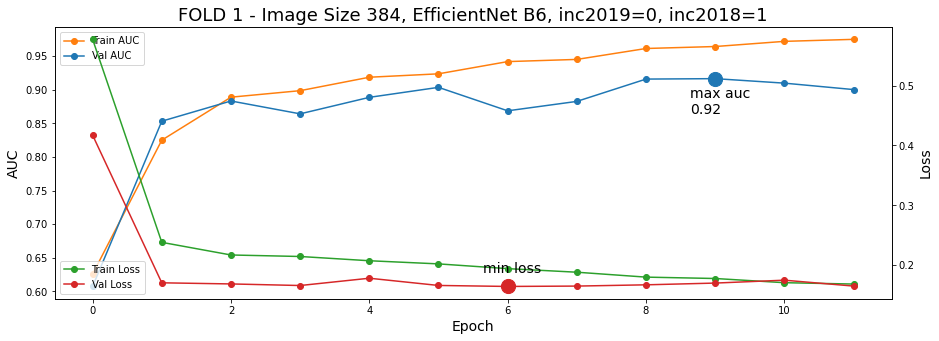

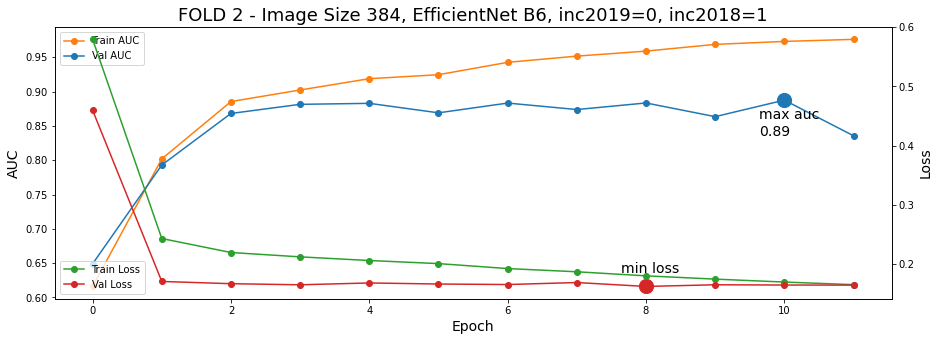

# Final submission

In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [ ]:
adias_submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
adias_submission = submission.sort_values('image_name') 
adias_submission.to_csv('adias_submission.csv', index=False)

In [ ]:
adias_submission.head()